This jupyter notebook contains the informations related to the task from Mohirdev platform

    Predicting the prices of airplane tickets

Author : Umidjon Sattorov. Student at Mohirdev platform

    Data uploading and initial acquitance

In [5]:
#Importing essential libraries
import pandas as pd
import numpy as np 

#Visualization 
import matplotlib.pyplot as plt
import seaborn as sns 

#Machine learning algorithms, metrics and feature engineering tools 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Modelling 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import fastai 
from fastai.tabular.all import *
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import TheilSenRegressor
from sklearn.manifold import TSNE

#Preserving machine learning model
import pickle as pkl

In [6]:
#Data uploading
df = pd.read_csv(filepath_or_buffer = './data/train_data.csv', sep = ",", index_col = 'id')
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
id,,,,,,,,,,,
1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


Dataset information : 

1) Id = indentification number of customer
2) Airline - travel organizator company
3) flight - flight number
4) source_city - departure city
5) departure_time - the time for departure 
6) stop - the number of stops during commutation
7) destination_city - arrival city
8) arrival_time - the time of arrival
9) price - the price of ticket
10) class - the class of user who purchased particular ticket for travel
11) days_left - when the airplane is going to come back home.

In [126]:
#Checking the emptyness of given dataset
print("The emptyness of given dataset :")
df.isna().sum()

The emptyness of given dataset :


airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

Conclusion : So far, we have tested the number of Nan values for each column of the dataset. It seems like there is not any empty values in the given dataset(So I don't have to worry about such problem anymore).

In [4]:
#Checking the number of unique values for each column of the dataset
for i in df.columns :
    print(f"The column {i} contains : {df[i].nunique()} values")

The column airline contains : 6 values
The column flight contains : 1310 values
The column source_city contains : 6 values
The column departure_time contains : 6 values
The column stops contains : 3 values
The column arrival_time contains : 6 values
The column destination_city contains : 6 values
The column class contains : 2 values
The column duration contains : 404 values
The column days_left contains : 49 values
The column price contains : 4420 values


In [7]:
#Reducing the number of unique value in the column named 'flight' to save computing resources
df['flight'] = df['flight'].apply(lambda x : x[0 : 2])

In [6]:
#Checking the number of unique values for each column of the dataset
for i in df.columns :
    print(f"The column {i} contains : {df[i].nunique()} values")

The column airline contains : 6 values
The column flight contains : 6 values
The column source_city contains : 6 values
The column departure_time contains : 6 values
The column stops contains : 3 values
The column arrival_time contains : 6 values
The column destination_city contains : 6 values
The column class contains : 2 values
The column duration contains : 404 values
The column days_left contains : 49 values
The column price contains : 4420 values


In [7]:
df['stops'].value_counts()

stops
one            16666
zero            2440
two_or_more      894
Name: count, dtype: int64

In [8]:
df['stops'] = df['stops'].apply(lambda x : 0 if (x == 'zero') else 1 if (x == 'one') else 2)
df['stops'].value_counts()

stops
1    16666
0     2440
2      894
Name: count, dtype: int64

In [133]:
#Saving analysis ready dataset
df.to_csv('./data/analysis_ready_dataset.csv', index = False)
print("File has been saved successfully")

File has been saved successfully


    Data analysis and data preparation stage

In [134]:
#Checking the correlation between numerical values and our target column
corr = df[['stops', 'duration', 'days_left', 'price']].corr()
corr

,stops,duration,days_left,price
stops,1.000000,0.470493,0.003238,0.121455
duration,0.470493,1.000000,-0.020091,0.213158
days_left,0.003238,-0.020091,1.000000,-0.102545
price,0.121455,0.213158,-0.102545,1.000000


Because in the jupyter notebook which we used for analysis purpose, we found highly correlated features. This may lead to the problem of multicollinearity in our regression model. That is why I am going to remove the feature airline from my dataset.

In [9]:
df.drop(columns = 'airline', inplace = True)

    Feature engineering 

For this problem, I am going to use one hot encoder, label encoder and hash encoders for categorical features. For numerical features, I am going to use Standart Normalizer(or MinMax normalizer - that really depends)

In [10]:
ohe_cols = ['source_city', 'departure_time', 'arrival_time', 'destination_city', 'class', 'flight']
std_scaler = ['duration', 'days_left', 'price']

#One Hot encoding
ohe = OneHotEncoder(sparse_output = False)
ohe_data = ohe.fit_transform(df[ohe_cols])
df[ohe.get_feature_names_out()] = ohe_data

#Standart scaler
std_scl = StandardScaler()
std_scaled = std_scl.fit_transform(df[std_scaler])
std_scaled_cols = [x + '_std' for x in std_scaler]
df[std_scaled_cols] = std_scaled

df.drop(columns = ohe_cols + std_scaler, inplace = True)
df.head()

,stops,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,...,class_Economy,flight_6E,flight_AI,flight_G8,flight_I5,flight_SG,flight_UK,duration_std,days_left_std,price_std
id,,,,,,,,,,,,,,,,,,,,,
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.289528,-0.361418,-0.603660
2,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.456827,-1.388976,-0.687963
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.362910,-1.535770,1.738437
4,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.758285,0.152361,-0.667414
5,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.421900,-1.609167,-0.449982


In [13]:
df.to_csv(path_or_buf = './data/train_ready.csv', sep = ',')
print("Dataset for training machine learning algorithm is preserved successfully !")

Dataset for training machine learning algorithm is preserved successfully !


    Modelling

For making model I am going to try four algorithms : MLP multilayer perceptron, logistic regression and tabular learner from fastai. Model performance is measured using accuracy score.

In [12]:
#Data loading and separating into train, test features
model_data = pd.read_csv(filepath_or_buffer = './data/train_ready.csv', sep = ',')
x = model_data.drop(columns = ['id', 'price_std'])
y = model_data['price_std']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#Teaching model using MLPRegression 
mlp_reg = MLPRegressor(random_state = 1, max_iter = 1000).fit(x_train, y_train)

In [14]:
pred_train = mlp_reg.predict(X = x_train)
pred_test = mlp_reg.predict(X = x_test)

print(f"Mean absolute error of MLP regression in train dataset is {mean_absolute_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean absolute error of MLP regression in test dataset is {mean_absolute_error(y_true = y_test, y_pred = pred_test)}")
print(f"Mean squared error of MLP regression in train dataset is {mean_squared_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean squared error of MLP regression in test dataset is {mean_squared_error(y_true = y_test, y_pred = pred_test)}")
print(f"R2 score of MLP regression in train dataset is {r2_score(y_true = y_train, y_pred = pred_train)}")
print(f"R2 score of MLP regression in test dataset is {r2_score(y_true = y_test, y_pred = pred_test)}")

Mean absolute error of MLP regression in train dataset is 0.35528357034492786
Mean absolute error of MLP regression in test dataset is 0.35147504712966915
Mean squared error of MLP regression in train dataset is 0.20828360600080184
Mean squared error of MLP regression in test dataset is 0.20782951025093288
R2 score of MLP regression in train dataset is 0.7910680372059606
R2 score of MLP regression in test dataset is 0.7947115057729021


In [15]:
#Manual search of optimal hyperparameters
mlp = MLPRegressor(max_iter = 1000, hidden_layer_sizes = (100, 100), activation = 'relu', solver = 'lbfgs', learning_rate_init = 1, learning_rate = 'adaptive', alpha = 0.001, random_state = 1).fit(x_train, y_train)

pred_train = mlp.predict(X = x_train)
pred_test = mlp.predict(X = x_test)

print(f"Mean absolute error of MLP regression in train dataset is {mean_absolute_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean absolute error of MLP regression in test dataset is {mean_absolute_error(y_true = y_test, y_pred = pred_test)}")
print(f"Mean squared error of MLP regression in train dataset is {mean_squared_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean squared error of MLP regression in test dataset is {mean_squared_error(y_true = y_test, y_pred = pred_test)}")
print(f"R2 score of MLP regression in train dataset is {r2_score(y_true = y_train, y_pred = pred_train)}")
print(f"R2 score of MLP regression in test dataset is {r2_score(y_true = y_test, y_pred = pred_test)}")

Mean absolute error of MLP regression in train dataset is 0.2176941468443541
Mean absolute error of MLP regression in test dataset is 0.21618056288267767
Mean squared error of MLP regression in train dataset is 0.10017895856677134
Mean squared error of MLP regression in test dataset is 0.09990591432030328
R2 score of MLP regression in train dataset is 0.8995091987991715
R2 score of MLP regression in test dataset is 0.9013155798210112


In [56]:
#Saving machine learning models into pickle format
pkl.dump(mlp, open('./models/mlp_reg_relu.pkl', 'wb'))
print("Model saved successfully!")

Model saved successfully!


Well MLP regressor algorithm just performed outstandingly and returned average 0.22 mean absolute error and average 0.99 mean squared error. It doesn't overtrained as there is not difference between the metric for training and test datasets. 

In [139]:
df_fastai = pd.read_csv(filepath_or_buffer = './data/analysis_ready_dataset.csv', sep = ',')
df_fastai.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,Vistara,UK,Bangalore,Early_Morning,1,Night,Mumbai,Economy,14.25,21,7212
1,SpiceJet,SG,Hyderabad,Evening,0,Night,Kolkata,Economy,1.75,7,5292
2,Vistara,UK,Bangalore,Morning,1,Evening,Delhi,Business,9.58,5,60553
3,Vistara,UK,Kolkata,Morning,1,Evening,Hyderabad,Economy,6.75,28,5760
4,Indigo,6E,Chennai,Early_Morning,0,Morning,Mumbai,Economy,2.00,4,10712


In [149]:
df_fastai.dtypes[(df_fastai.dtypes == 'int64') | (df_fastai.dtypes == 'float')].index.to_list()

['stops', 'duration', 'days_left', 'price']

In [152]:
#Fastai model
train_data, test_data = train_test_split(df_fastai, test_size = 0.2, random_state = 42)
dls = TabularDataLoaders.from_df(df = train_data, bs = 16, y_names = 'price', skipinitialspace = False, cat_names = df_fastai.dtypes[df_fastai.dtypes == 'object'].index.to_list(), cont_names = df_fastai.dtypes[(df_fastai.dtypes == 'int64') | (df_fastai.dtypes == 'float')].index.to_list(), procs = [Categorify, Normalize])
learn = tabular_learner(dls = dls, metrics = mae)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,mae,time
0,0.082723,0.021034,0.126233,00:06
1,0.090916,0.021687,0.128831,00:05
2,0.093414,0.022729,0.101589,00:05
3,0.065214,0.026711,0.112767,00:05


In [153]:
test_dls = dls.test_dl(test_data)
preds, targs = learn.get_preds(dl = test_dls)

print(f"Mean absolute error of the model in the test dataset is : { mean_absolute_error(targs, preds)}")


Mean absolute error of the model in the test dataset is : 0.11611131578683853


In [154]:
pkl.dump(learn, open('./models/fastai_model.pkl', 'wb'))

Tabular learner from fastai library just returned outstanding scores as well(even better than mlp regressor algorithm)

### Random Forest regressor algorithms

In [16]:
#Random Forest regressor algorithm
rm = RandomForestRegressor(random_state = 1).fit(x_train, y_train)

pred_train = rm.predict(X = x_train)
pred_test = rm.predict(X = x_test)

print(f"Mean absolute error of Random Forest Regressor algorithm in train dataset is {mean_absolute_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean absolute error of Random Forest Regressor algorithm in test dataset is {mean_absolute_error(y_true = y_test, y_pred = pred_test)}")
print(f"Mean squared error of Random Forest Regressor algorithm in train dataset is {mean_squared_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean squared error of Random Forest Regressor algorithm in test dataset is {mean_squared_error(y_true = y_test, y_pred = pred_test)}")
print(f"R2 score of Random Forest Regressor algorithm in train dataset is {r2_score(y_true = y_train, y_pred = pred_train)}")
print(f"R2 score of Random Forest Regressor algorithm in test dataset is {r2_score(y_true = y_test, y_pred = pred_test)}")

Mean absolute error of Random Forest Regressor algorithm in train dataset is 0.03503086560050342
Mean absolute error of Random Forest Regressor algorithm in test dataset is 0.09368342708623467
Mean squared error of Random Forest Regressor algorithm in train dataset is 0.004270410340013201
Mean squared error of Random Forest Regressor algorithm in test dataset is 0.031221463911447433
R2 score of Random Forest Regressor algorithm in train dataset is 0.9957162964891654
R2 score of Random Forest Regressor algorithm in test dataset is 0.9691602635919797


Wow, Random Forest regressor might provide better results than MLP Regressor as the initial results suggests. I am going to find optimal hyperparameters for this algorithms also manually(GridSearch is taking more time than needed).

In [17]:
#Random Forest regressor algorithm with optimal hyperparameters
rm_optimal = RandomForestRegressor(random_state = 1, n_estimators = 100, min_samples_split = 20, min_samples_leaf = 8, bootstrap = True).fit(x_train, y_train)

pred_train = rm_optimal.predict(X = x_train)
pred_test = rm_optimal.predict(X = x_test)

print(f"Mean absolute error of Random Forest Regressor algorithm in train dataset is {mean_absolute_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean absolute error of Random Forest Regressor algorithm in test dataset is {mean_absolute_error(y_true = y_test, y_pred = pred_test)}")
print(f"Mean squared error of Random Forest Regressor algorithm in train dataset is {mean_squared_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean squared error of Random Forest Regressor algorithm in test dataset is {mean_squared_error(y_true = y_test, y_pred = pred_test)}")
print(f"R2 score of Random Forest Regressor algorithm in train dataset is {r2_score(y_true = y_train, y_pred = pred_train)}")
print(f"R2 score of Random Forest Regressor algorithm in test dataset is {r2_score(y_true = y_test, y_pred = pred_test)}")

Mean absolute error of Random Forest Regressor algorithm in train dataset is 0.08534562070781422
Mean absolute error of Random Forest Regressor algorithm in test dataset is 0.10139899940777226
Mean squared error of Random Forest Regressor algorithm in train dataset is 0.024249686895164685
Mean squared error of Random Forest Regressor algorithm in test dataset is 0.03450897657758228
R2 score of Random Forest Regressor algorithm in train dataset is 0.9756748273307303
R2 score of Random Forest Regressor algorithm in test dataset is 0.9659129455178117


With hyperparameter fine tuning, I made the result a little bit worse in order to avoid overtraining issue and I think, I have made it. My Random Forest Regression model returned average 0.9 mean absolute error and 0.3 mean squared error which is pretty amazing.

### Using CatBoost Regressor model

Most of the time when Random Forest algorithms perform well on the problem, gradient boosting algorithms also do pretty well on this kind of problems. That is why I am going to use some gradient boosting algorithms to solve the problem prediction the cost of the flights.

In [18]:
# CatBoost Regressor algorithm with optimal hyperparameters
catboost_optimal = CatBoostRegressor(
    random_state = 1,
    iterations = 300,
    learning_rate = 0.1,
    depth = 6,
    l2_leaf_reg = 2,
    loss_function = 'RMSE',
    logging_level = 'Silent'
).fit(x_train, y_train)

pred_train = catboost_optimal.predict(x_train)
pred_test = catboost_optimal.predict(x_test)

print(f"Mean absolute error of CatBoost regression in train dataset is {mean_absolute_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean absolute error of CatBoost regression in test dataset is {mean_absolute_error(y_true = y_test, y_pred = pred_test)}")
print(f"Mean squared error of CatBoost regression in train dataset is {mean_squared_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean squared error of CatBoost regression in test dataset is {mean_squared_error(y_true = y_test, y_pred = pred_test)}")
print(f"R2 score of CatBoost regression in train dataset is {r2_score(y_true = y_train, y_pred = pred_train)}")
print(f"R2 score of CatBoost regression in test dataset is {r2_score(y_true = y_test, y_pred = pred_test)}")

Mean absolute error of CatBoost regression in train dataset is 0.10020077604314251
Mean absolute error of CatBoost regression in test dataset is 0.10798504227018633
Mean squared error of CatBoost regression in train dataset is 0.02776830666681743
Mean squared error of CatBoost regression in test dataset is 0.034780683594735635
R2 score of CatBoost regression in train dataset is 0.972145254603751
R2 score of CatBoost regression in test dataset is 0.965644560511491


Catboost regressor algorithms doesn't perform well than Random Forest Regressor, that is why we keep only the Random Forest.

### SVR - Support Vector Regressor algorithm

In [19]:
#Using SVR algorithms for car price prediction model
svr_optimal = SVR(kernel = 'poly', C = 2000, epsilon = 0.1, gamma = 'scale').fit(x_train, y_train)

pred_train = svr_optimal.predict(X = x_train)
pred_test = svr_optimal.predict(X = x_test)

print(f"Mean absolute error of SVR in train dataset is {mean_absolute_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean absolute error of SVR in test dataset is {mean_absolute_error(y_true = y_test, y_pred = pred_test)}")
print(f"Mean squared error of SVR in train dataset is {mean_squared_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean squared error of SVR in test dataset is {mean_squared_error(y_true = y_test, y_pred = pred_test)}")
print(f"R2 score of SVR in train dataset is {r2_score(y_true = y_train, y_pred = pred_train)}")
print(f"R2 score of SVR in test dataset is {r2_score(y_true = y_test, y_pred = pred_test)}")

Mean absolute error of SVR in train dataset is 0.5614185756483335
Mean absolute error of SVR in test dataset is 0.5714062926792185
Mean squared error of SVR in train dataset is 0.8521238115995294
Mean squared error of SVR in test dataset is 0.8758760340629392
R2 score of SVR in train dataset is 0.1452236500056444
R2 score of SVR in test dataset is 0.1348328158725669


Well Support Vector machine algorithms does performed well for the prediction of flight prices. After fine-tuning the hyperparameters of the model, I get average 0.57 mean absolute error and 0.86 mean squared error which is pretty much great, but not outstanding as other model's results.

### Theil-Sen regressor algorithm

Because this is the first time I have ever used this algorithms, I think it is better to mention what I have found from the internet about this algorithms.

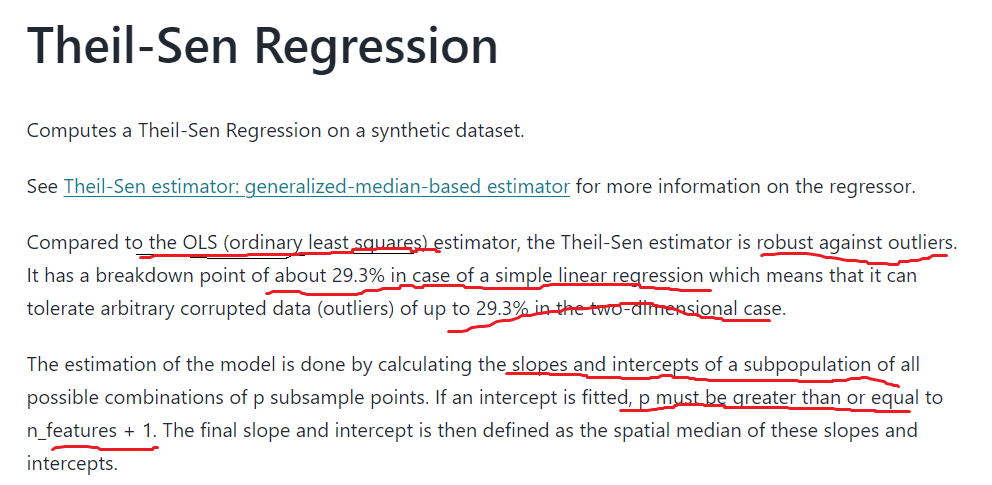

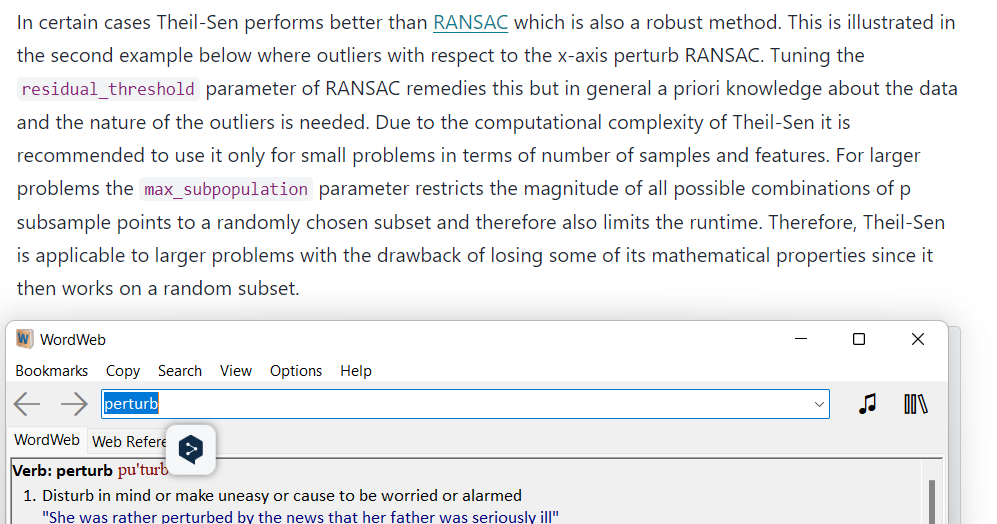

Further information can be found in informative notebooks file.

In [ ]:
param_grid = {
    'max_subpopulation': [1e4, 1e5, 1e6],
    'max_iter': [300, 500, 1000],
    'tol': [1e-3, 1e-4, 1e-5],
    'fit_intercept': [True, False],
}

In [16]:
#Using theil_sen regressor algorithm 
theil_sen_optimal = TheilSenRegressor(random_state=1, max_iter = 300, tol = 0.001, max_subpopulation = 10000, fit_intercept = True).fit(x_train, y_train)

pred_train = theil_sen_optimal.predict(x_train)
pred_test = theil_sen_optimal.predict(x_test)

print(f"Mean absolute error of Theil-Sen regression in train dataset is {mean_absolute_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean absolute error of Theil-Sen regression in test dataset is {mean_absolute_error(y_true = y_test, y_pred = pred_test)}")
print(f"Mean squared error of Theil-Sen regression in train dataset is {mean_squared_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean squared error of Theil-Sen regression in test dataset is {mean_squared_error(y_true = y_test, y_pred = pred_test)}")
print(f"R2 score of Theil-Sen regression in train dataset is {r2_score(y_true = y_train, y_pred = pred_train)}")
print(f"R2 score of Theil-Sen regression in test dataset is {r2_score(y_true = y_test, y_pred = pred_test)}")

Mean absolute error of Theil-Sen regression in train dataset is 0.19862323497802714
Mean absolute error of Theil-Sen regression in test dataset is 0.1971955440189353
Mean squared error of Theil-Sen regression in train dataset is 0.08858015959617337
Mean squared error of Theil-Sen regression in test dataset is 0.08806965500660119
R2 score of Theil-Sen regression in train dataset is 0.9111441031563161
R2 score of Theil-Sen regression in test dataset is 0.9130071237642057


Wow, even the model TheilSenRegressor performed well when it comes to predict the price of the flights.

### Using Extra Trees regression model

In [21]:
# Extra Trees regression model with some tuned hyperparameters
extra_trees_optimal = ExtraTreesRegressor(
    n_estimators = 100, 
    random_state = 1, 
    n_jobs = -1
).fit(x_train, y_train)

pred_train = extra_trees_optimal.predict(x_train)
pred_test = extra_trees_optimal.predict(x_test)

print(f"Mean absolute error of Extra Trees regression in train dataset is {mean_absolute_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean absolute error of Extra Trees regression in test dataset is {mean_absolute_error(y_true = y_test, y_pred = pred_test)}")
print(f"Mean squared error of Extra Trees regression in train dataset is {mean_squared_error(y_true = y_train, y_pred = pred_train)}")
print(f"Mean squared error of Extra Trees regression in test dataset is {mean_squared_error(y_true = y_test, y_pred = pred_test)}")
print(f"R2 score of Extra Trees regression in train dataset is {r2_score(y_true = y_train, y_pred = pred_train)}")
print(f"R2 score of Extra Trees regression in test dataset is {r2_score(y_true = y_test, y_pred = pred_test)}")


Mean absolute error of Extra Trees regression in train dataset is 9.596878616769355e-16
Mean absolute error of Extra Trees regression in test dataset is 0.08906465969175431
Mean squared error of Extra Trees regression in train dataset is 1.6276738679055223e-30
Mean squared error of Extra Trees regression in test dataset is 0.03178577984335149
R2 score of Extra Trees regression in train dataset is 1.0
R2 score of Extra Trees regression in test dataset is 0.9686028472376368


Model seems like there is overtrain in ExtraTreesRegression model, but it performed well in the test dataset, that is why I don't think so.

Conclusion : I have tried many machine learning models to solve the problem of prediction of the cost of the flights. Because the quality of the data was astonishingly good, I didn't feel any hardships to create machine learning models. Almost every models just performed well and find the common pattern in the data. But among them the tree based models outperformed when it comes to predicting the price of the flights compared to the other models.

In [22]:
#Extracting five rows of data from the dataset for validation purposes
df[df.index.isin(y_test.sample(5).index)].to_csv(path_or_buf = './data/validation_extraction.csv')
print("Data is preserved successfully!")

Data is preserved successfully!
